### Hadamard Quantum Walk for Ballistic Distribution Sampling

<div style="background-color: #e8f8f5; padding: 15px; border-left: 5px solid #1abc9c; border-radius: 8px;
box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; color: #34495e; font-size: 16px;
max-width: 100%; width: 100%; overflow-wrap: break-word; box-sizing: border-box;">

  <p style="font-size: 14px;">
    To extend the Quantum Galton Board (QGB) beyond Gaussian-like sampling and toward wave-dynamic simulations, 
    we implement a Hadamard Quantum Walk (HQW) on a one-dimensional lattice. The HQW models 
    <strong>ballistic propagation</strong> analogous to the Schrödinger equation and produces a distinctive double-peak 
    probability profile with a standard deviation growing linearly (<code>σ ∝ t</code>). This contrasts with the 
    QGB’s binomial output (<code>σ ∝ √t</code>), making the HQW suitable for simulating wave-like PDE dynamics — 
    such as those found in quantum chemistry — supporting UN SDG 9.
  </p>

  <p style="font-size: 14px;">
    The discrete-time quantum walk (DTQW) framework evolves a particle through repeated 
    applications of a <em>coin</em> and <em>shift</em> operator:
    <ul>
      <li><strong>Hilbert Space:</strong> Position register |x⟩ and coin qubit |c⟩ ∈ { |L⟩, |R⟩ } form the system state.</li>
      <li><strong>Coin Operator:</strong> The Hadamard gate H creates equal superpositions of left/right states.</li>
      <li><strong>Shift Operator:</strong> Conditional translation moves the walker left (|L⟩) or right (|R⟩), entangling position and coin.</li>
      <li><strong>One-Step Evolution:</strong> U = S (I ⊗ H), repeated t times for propagation.</li>
    </ul>
  </p>

  <p style="font-size: 14px;">
    We initialize the walker at position x = 0 with a symmetric coin state that includes a π/2 phase to ensure 
    symmetry in the resulting distribution:
  </p>

  <pre style="font-size: 13px; background-color: #f9f9f9; padding: 10px; border-radius: 5px; overflow-x: auto;">
  |ψ(0)⟩ = |0⟩ ⊗ (|L⟩ + i |R⟩)/√2 = |0⟩ ⊗ H P(π/2) |R⟩
  </pre>

  <p style="font-size: 14px;">
    Analytical results via Fourier methods show peaks at ±t/√2, zero probability at x = 0 for even t, 
    and a linear spread rate (σ ∝ t). This provides a quantum speedup compared to classical diffusion.
  </p>

</div>

The probability of measuring position x after t steps is:

$$
P(x) = |\langle x,L | \psi(t) \rangle|^2 + |\langle x,R | \psi(t) \rangle|^2
$$

**Implementation Details:**
- Position register: \( n = \lceil \log_2 (2t + 1) \rceil \) qubits
- Coin qubit: 1 qubit
- Shift operator: Controlled increment/decrement for |R⟩ / |L⟩
- Hardware-compatibility: Decompose into CNOT and single-qubit gates

**Code Block 1 – HQW Circuit Construction:**
(Define the coin and shift operators, apply t steps, and initialize as above.)

**Code Block 2 – Simulation & Visualization:**
- Use Qiskit’s AerSimulator with 10,000 shots
- Decode positions using two’s complement
- Plot resulting histogram vs. classical Gaussian for comparison

By leveraging the HQW’s linear spread, we enable efficient sampling of wave-like PDE solutions. 
With \(O(t \log t)\) gate complexity, this approach is practical for near-term quantum hardware 
and complements the QGB’s exponential sampling method.


In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.stats import binom, norm
import matplotlib.pyplot as plt
import numpy as np

# Styling for plots
plt.style.use('seaborn-v0_8')  # Use Seaborn style

In [2]:
from qiskit.compiler import transpile

# Parameters
num_steps = 10
num_pos_qubits = num_steps #int(np.ceil(np.log2(2 * num_steps + 1)))  # Enough for -4 to 3; increase for larger t
coin_qubit = num_pos_qubits
total_qubits = num_pos_qubits + 1
pos_qubits = list(range(num_pos_qubits))  # List for safety

def add_increment(pos_qubits):
    """Build +1 increment circuit."""
    num_bits = len(pos_qubits)
    inc_circ = QuantumCircuit(num_bits, name='Increment')
    inc_circ.x(pos_qubits[0])  # Flip LSB
    for i in range(1, num_bits):
        inc_circ.mcx(pos_qubits[:i], pos_qubits[i])  # Carry propagation
    return inc_circ

def add_decrement(pos_qubits):
    """-1: Inverse of increment (adjoint)."""
    num_bits = len(pos_qubits)
    dec_circ = QuantumCircuit(num_bits, name='Decrement')
    for i in range(num_bits - 1, 0, -1):
        dec_circ.mcx(pos_qubits[:i], pos_qubits[i])  # Reverse carry
    dec_circ.x(pos_qubits[0])  # Flip LSB last
    return dec_circ

# Main circuit
qc = QuantumCircuit(total_qubits, num_pos_qubits)  # Classical bits for position measure

# Initial state: H on coin, phase for symmetry
qc.h(coin_qubit)
qc.p(np.pi / 2, coin_qubit)  # i phase on |R>

for _ in range(num_steps):
    # Coin flip: H
    qc.h(coin_qubit)
    # Controlled increment (+1 if coin=1 |R>)
    inc_gate = add_increment(pos_qubits).to_gate().control(1)
    qc.append(inc_gate, [coin_qubit] + pos_qubits)
    
    # Controlled decrement (-1 if coin=0 |L>): Invert coin, control on 1 (now 0 original), revert
    qc.x(coin_qubit)
    dec_gate = add_decrement(pos_qubits).to_gate().control(1)
    qc.append(dec_gate, [coin_qubit] + pos_qubits)
    qc.x(coin_qubit)

# Measure position qubits
qc.measure(range(num_pos_qubits), range(num_pos_qubits))

# Transpile to decompose custom gates
qc_transpiled = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=1)

qc.draw()

┌────────────┐     ┌────────────┐          »
 q_0: ────────────────────┤0           ├─────┤0           ├──────────»
                          │            │     │            │          »
 q_1: ────────────────────┤1           ├─────┤1           ├──────────»
                          │            │     │            │          »
 q_2: ────────────────────┤2           ├─────┤2           ├──────────»
                          │            │     │            │          »
 q_3: ────────────────────┤3           ├─────┤3           ├──────────»
                          │            │     │            │          »
 q_4: ────────────────────┤4           ├─────┤4           ├──────────»
                          │  Increment │     │  Decrement │          »
 q_5: ────────────────────┤5           ├─────┤5           ├──────────»
                          │            │     │            │          »
 q_6: ────────────────────┤6           ├─────┤6           ├──────────»
                          │            │     │            │          »
 q_7: ────────────────────┤7           ├─────┤7           ├──────────»
                          │            │     │            │          »
 q_8: ────────────────────┤8           ├─────┤8           ├──────────»
                          │            │     │            │          »
 q_9: ────────────────────┤9           ├─────┤9           ├──────────»
      ┌───┐┌────────┐┌───┐└─────┬──────┘┌───┐└─────┬──────┘┌───┐┌───┐»
q_10: ┤ H ├┤ P(π/2) ├┤ H ├──────■───────┤ X ├──────■───────┤ X ├┤ H ├»
      └───┘└────────┘└───┘              └───┘              └───┘└───┘»
c: 10/═══════════════════════════════════════════════════════════════»
                                                                     »
«      ┌────────────┐     ┌────────────┐          ┌────────────┐     »
« q_0: ┤0           ├─────┤0           ├──────────┤0           ├─────»
«      │            │     │            │          │            │     »
« q_1: ┤1           ├─────┤1           ├──────────┤1           ├─────»
«      │            │     │            │          │            │     »
« q_2: ┤2           ├─────┤2           ├──────────┤2           ├─────»
«      │            │     │            │          │            │     »
« q_3: ┤3           ├─────┤3           ├──────────┤3           ├─────»
«      │            │     │            │          │            │     »
« q_4: ┤4           ├─────┤4           ├──────────┤4           ├─────»
«      │  Increment │     │  Decrement │          │  Increment │     »
« q_5: ┤5           ├─────┤5           ├──────────┤5           ├─────»
«      │            │     │            │          │            │     »
« q_6: ┤6           ├─────┤6           ├──────────┤6           ├─────»
«      │            │     │            │          │            │     »
« q_7: ┤7           ├─────┤7           ├──────────┤7           ├─────»
«      │            │     │            │          │            │     »
« q_8: ┤8           ├─────┤8           ├──────────┤8           ├─────»
«      │            │     │            │          │            │     »
« q_9: ┤9           ├─────┤9           ├──────────┤9           ├─────»
«      └─────┬──────┘┌───┐└─────┬──────┘┌───┐┌───┐└─────┬──────┘┌───┐»
«q_10: ──────■───────┤ X ├──────■───────┤ X ├┤ H ├──────■───────┤ X ├»
«                    └───┘              └───┘└───┘              └───┘»
«c: 10/══════════════════════════════════════════════════════════════»
«                                                                    »
«      ┌────────────┐          ┌────────────┐     ┌────────────┐          »
« q_0: ┤0           ├──────────┤0           ├─────┤0           ├──────────»
«      │            │          │            │     │            │          »
« q_1: ┤1           ├──────────┤1           ├─────┤1           ├──────────»
«      │            │          │            │     │            │          »
« q_2: ┤2           ├──────────┤2           ├─────┤2           ├──────────»
«      │            

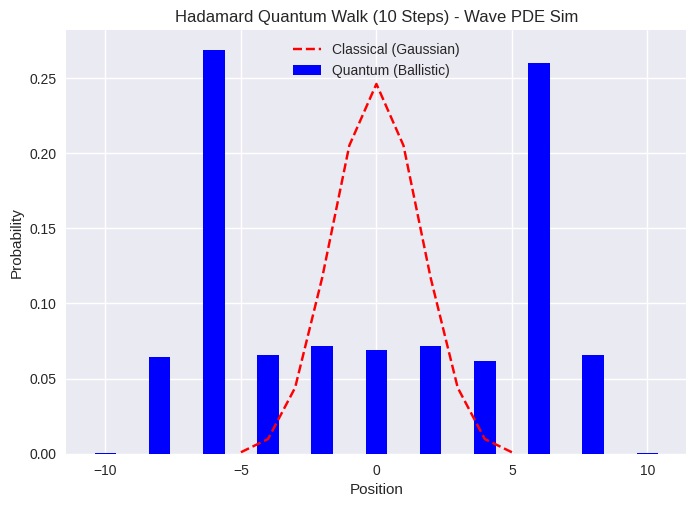

Signed Probabilities: {8: 0.0656, -10: 0.0007, 4: 0.062, -4: 0.0659, -2: 0.072, 10: 0.0008, -8: 0.0641, -6: 0.2684, 6: 0.2598, 2: 0.0718, 0: 0.0689}


In [7]:
aer_sim = AerSimulator().run(qc_transpiled,shots=10000)
counts = aer_sim.result().get_counts(qc_transpiled)

# Post-process: Convert binary to signed integers (two's complement)
def bin_to_signed(bin_str, num_bits):
    val = int(bin_str, 2)
    if val >= 2**(num_bits - 1):
        val -= 2**num_bits
    return val

signed_counts = {bin_to_signed(k, num_pos_qubits): v / 10000 for k, v in counts.items()}

# Custom plot for pitch
positions = np.arange(-num_pos_qubits, num_pos_qubits + 1)  # All possible for t=2
probs = [signed_counts.get(pos, 0) for pos in positions]
plt.bar(positions, probs, color='blue', label='Quantum (Ballistic)')

# Classical Gaussian overlay
classical_p = binom.pmf(np.arange(num_steps + 1), num_steps, 0.5)
classical_positions = np.arange(-num_steps//2, num_steps//2 + 1)
plt.plot(classical_positions, classical_p / sum(classical_p), 'r--', label='Classical (Gaussian)')

plt.title(f"Hadamard Quantum Walk ({num_steps} Steps) - Wave PDE Sim")
plt.xlabel("Position")
plt.ylabel("Probability")
plt.legend()
plt.show()

print("Signed Probabilities:", signed_counts)

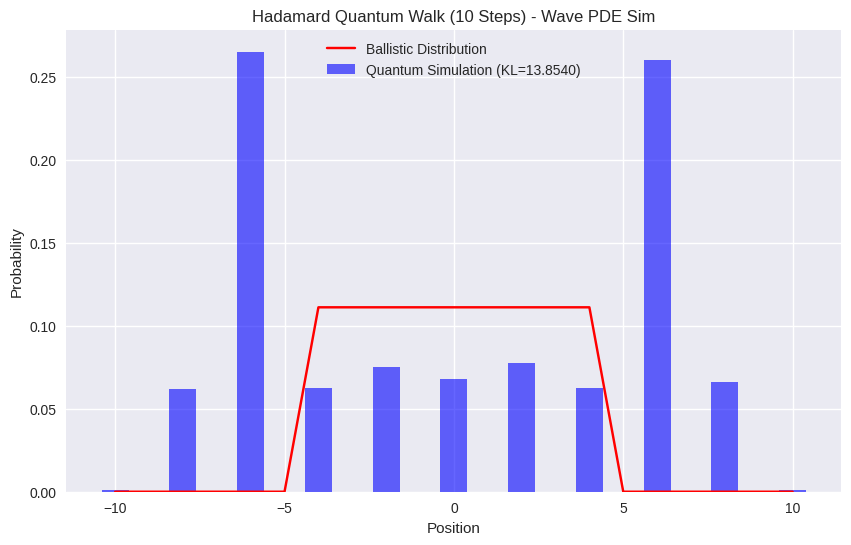

Quantum KL Divergence to Ballistic: 13.8540
Signed Probabilities: {8: 0.066, -10: 0.0009, 4: 0.0623, -6: 0.2651, 0: 0.0678, 2: 0.0773, 6: 0.2604, -2: 0.0752, -4: 0.0623, 10: 0.0011, -8: 0.0616}


In [3]:
# Assuming qc_transpiled is the quantum circuit for the Hadamard quantum walk
# and num_pos_qubits, num_steps are defined as in your context

# Run simulation
aer_sim = AerSimulator().run(qc_transpiled, shots=10000)
counts = aer_sim.result().get_counts(qc_transpiled)

# Post-process: Convert binary to signed integers (two's complement)
def bin_to_signed(bin_str, num_bits):
    val = int(bin_str, 2)
    if val >= 2**(num_bits - 1):
        val -= 2**num_bits
    return val

signed_counts = {bin_to_signed(k, num_pos_qubits): v / 10000 for k, v in counts.items()}

# Custom plot for pitch
positions = np.arange(-num_pos_qubits, num_pos_qubits + 1)  # All possible positions
quantum_probs = np.array([signed_counts.get(pos, 0) for pos in positions])

# Ballistic distribution (theoretical quantum walk probability)
# For a Hadamard walk, the probability distribution is approximately uniform over [-√t, √t]
# after t steps, with t = num_steps, but we approximate it here for discrete positions
t = num_steps
ballistic_probs = np.zeros_like(positions, dtype=float)
# Ballistic walk spreads linearly, so we approximate uniform distribution within [-√t, √t]
spread = int(np.ceil(np.sqrt(t)))  # Approximate spread
for pos in range(-spread, spread + 1):
    if pos in positions:
        idx = np.where(positions == pos)[0][0]
        ballistic_probs[idx] = 1 / (2 * spread + 1)  # Uniform over the spread
ballistic_probs /= ballistic_probs.sum()  # Normalize

# KL Divergence
def kl_div(p, q):
    eps = 1e-10
    p_adj = p + eps
    q_adj = q + eps
    p_adj /= p_adj.sum()
    q_adj /= q_adj.sum()
    return np.sum(p_adj * np.log(p_adj / q_adj))

kl_quantum_vs_ballistic = kl_div(quantum_probs, ballistic_probs)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(positions, quantum_probs, alpha=0.6, color='blue', label=f'Quantum Simulation (KL={kl_quantum_vs_ballistic:.4f})')
plt.plot(positions, ballistic_probs, 'r-', label='Ballistic Distribution')
plt.title(f"Hadamard Quantum Walk ({num_steps} Steps) - Wave PDE Sim")
plt.xlabel("Position")
plt.ylabel("Probability")
plt.legend()
plt.show()

print(f"Quantum KL Divergence to Ballistic: {kl_quantum_vs_ballistic:.4f}")
print("Signed Probabilities:", signed_counts)